In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class CoffeTimeSeriesAnalysis:
    def __init__(self, df):
        """
        Inicializa a análise com um Dataframe contendo colunas date e price
        """
        self.df = df.copy()
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df.set_index('date', inplace=True)

    def basic_statistics(self):
        """ Calcula estatisticas básicas da série"""
        stats = {
            'basic_stats': self.df['price'].describe(),
            'missing_values': self.df['price'].isnull().sum(),
            'total_periods': len(self.df),
            'date_range': (self.df.index.min(), self.df.index.max())
        }
        return stats

    def detect_outliers(self, z_theshold=3):
        """ Detecta outliers na série temporal usando o método Z-Score """
        z_scores = np.abs(stats.zscore(self.df['price']))
        outliers = self.df[z_scores > z_theshold].copy()
        return outliers

    def plot_analysis(self):
        """ Plota vizualizações da série temporal """
        fig, axes = plt.subplots(3,1, figsize=(12, 20))

        # Série temporal com outliers
        outliers = self.detect_outliers()
        axes[0].plot(self.df.index, self.df['price'], label='Preço')
        axes[0].scatter(outliers.index, outliers['price'], color='red', label='Outliers')
        axes[0].set_title('Série Temporal dos Preços do Café')
        axes[0].legend()

        # Boxplot por ano
        self.df['year'] = self.df.index.year
        sns.boxplot(data=self.df, x='year', y='price', ax=axes[1])
        axes[1].set_title('Distribuição de preços por ano')
        axes[1].tick_params(axis='x', rotation=45)

        # Decomposição da série temporal
        decomposition = seasonal_decompose(self.df['price'], period=12)
        axes[2].plot(decomposition.trend, label= 'Tendência', color='blue')
        axes[2].plot(decomposition.seasonal, label='Sazonalidade', color='green')
        axes[2].plot(decomposition.resid, label='Resíduo', color='red')
        axes[2].set_title('Decomposição da Série Temporal')
        axes[2].legend()

        plt.tight_layout()
        return fig
        
    def analyze_trends(self):
        """Analiza tendências na série temporal"""
        # Média móvel de diferentes períodos
        windows = [7, 30, 90]
        rolling_means = pd.DataFrame()
        
        for window in windows:
            rolling_means[f'MA_{window}'] = self.df['price'].rolling(window=window).mean()

        # Teste de estacionariedade
        adf_result = adfuller(self.df['price'].dropna())

        # Adicionando a visualização das médias móveis
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(self.df.index, self.df['price'], label='Preço', alpha=0.7)

        for window in windows:
            ax.plot(rolling_means.index, rolling_means[f'MA_{window}'], 
                   label=f'Média Móvel ({window} períodos)')

        ax.set_title('Preços e Médias Móveis')
        ax.legend()

        return {
            'rolling_means': rolling_means,
            'adf_test': {
                'statistics': adf_result[0],
                'p_value': adf_result[1],
                'is_stationary' : adf_result[1] < 0.05
            },
            'plot': fig
        }
    
    def seasonal_patterns(self):
        """Analisa padrões sazonais"""
        monthly_avg = self.df.groupby(self.df.index.month)['price'].mean()
        monthly_std = self.df.groupby(self.df.index.month)['price'].std()
        
        # Adicionando visualização dos padrões sazonais mensais
        fig, ax = plt.subplots(figsize=(10, 6))
        
        months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
                 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
        
        ax.bar(range(1, 13), monthly_avg, yerr=monthly_std, alpha=0.7)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(months)
        ax.set_title('Média Mensal de Preços do Café')
        ax.set_ylabel('Preço Médio')
        
        return {
            'monthly_average': monthly_avg,
            'monthly_std': monthly_std,
            'peak_month': monthly_avg.idxmax(),
            'lowest_month': monthly_avg.idxmin(),
            'plot': fig
        }

    def volatility_analysis(self):
        """Analise a volatilidade dos preços"""
        # Cálculo de retornos diários
        volatility_df = self.df.copy()
        volatility_df['returns'] = volatility_df['price'].pct_change()
        
        # Criando gráfico de volatilidade
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(volatility_df.index, volatility_df['returns'].rolling(window=30).std() * np.sqrt(252), 
                label='Volatilidade Anualizada (30 dias)')
        ax.set_title('Volatilidade dos Preços do Café')
        ax.set_ylabel('Volatilidade Anualizada')
        ax.legend()

        volatility = {
            'daily_volatility': volatility_df['returns'].std(),
            'annual_volatility': volatility_df['returns'].std() * np.sqrt(252),
            'max_daily_change': volatility_df['returns'].max(),
            'min_daily_change': volatility_df['returns'].min(),
            'plot': fig
        }
        return volatility
    
    def generate_summary(self):
        """Gera um resumo completo da análise"""
        basic_stats = self.basic_statistics()
        outliers = self.detect_outliers()
        trends = self.analyze_trends()
        seasonality = self.seasonal_patterns()
        volatility = self.volatility_analysis()
        
        # Gera um relatório visual completo
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        
        # Principais gráficos em uma única figura
        self.df['price'].plot(ax=axes[0, 0], title='Série Temporal dos Preços')
        
        if not outliers.empty:
            axes[0, 0].scatter(outliers.index, outliers['price'], color='red', 
                              label='Outliers', s=50)
            axes[0, 0].legend()
        
        # Plot de tendência e médias móveis
        self.df['price'].plot(ax=axes[0, 1], alpha=0.5, label='Preço')
        windows = [30, 90]
        for window in windows:
            self.df['price'].rolling(window=window).mean().plot(
                ax=axes[0, 1], label=f'MA {window}')
        axes[0, 1].set_title('Tendência e Médias Móveis')
        axes[0, 1].legend()
        
        # Plot sazonal mensal
        monthly_data = self.df.groupby(self.df.index.month)['price'].agg(['mean', 'std'])
        monthly_data['mean'].plot(kind='bar', yerr=monthly_data['std'], ax=axes[1, 0],
                                 title='Padrão Sazonal Mensal')
        axes[1, 0].set_xlabel('Mês')
        
        # Plot de volatilidade
        returns = self.df['price'].pct_change()
        returns.rolling(window=30).std().plot(ax=axes[1, 1], title='Volatilidade (30 dias)')
        
        plt.tight_layout()
        
        summary = {
            'basic_statistics': basic_stats,
            'outliers_count': len(outliers),
            'trend_analysis': trends,
            'seasonal_patterns': seasonality,
            'volatility_metrics': volatility,
            'summary_plot': fig
        }
        
        return summary

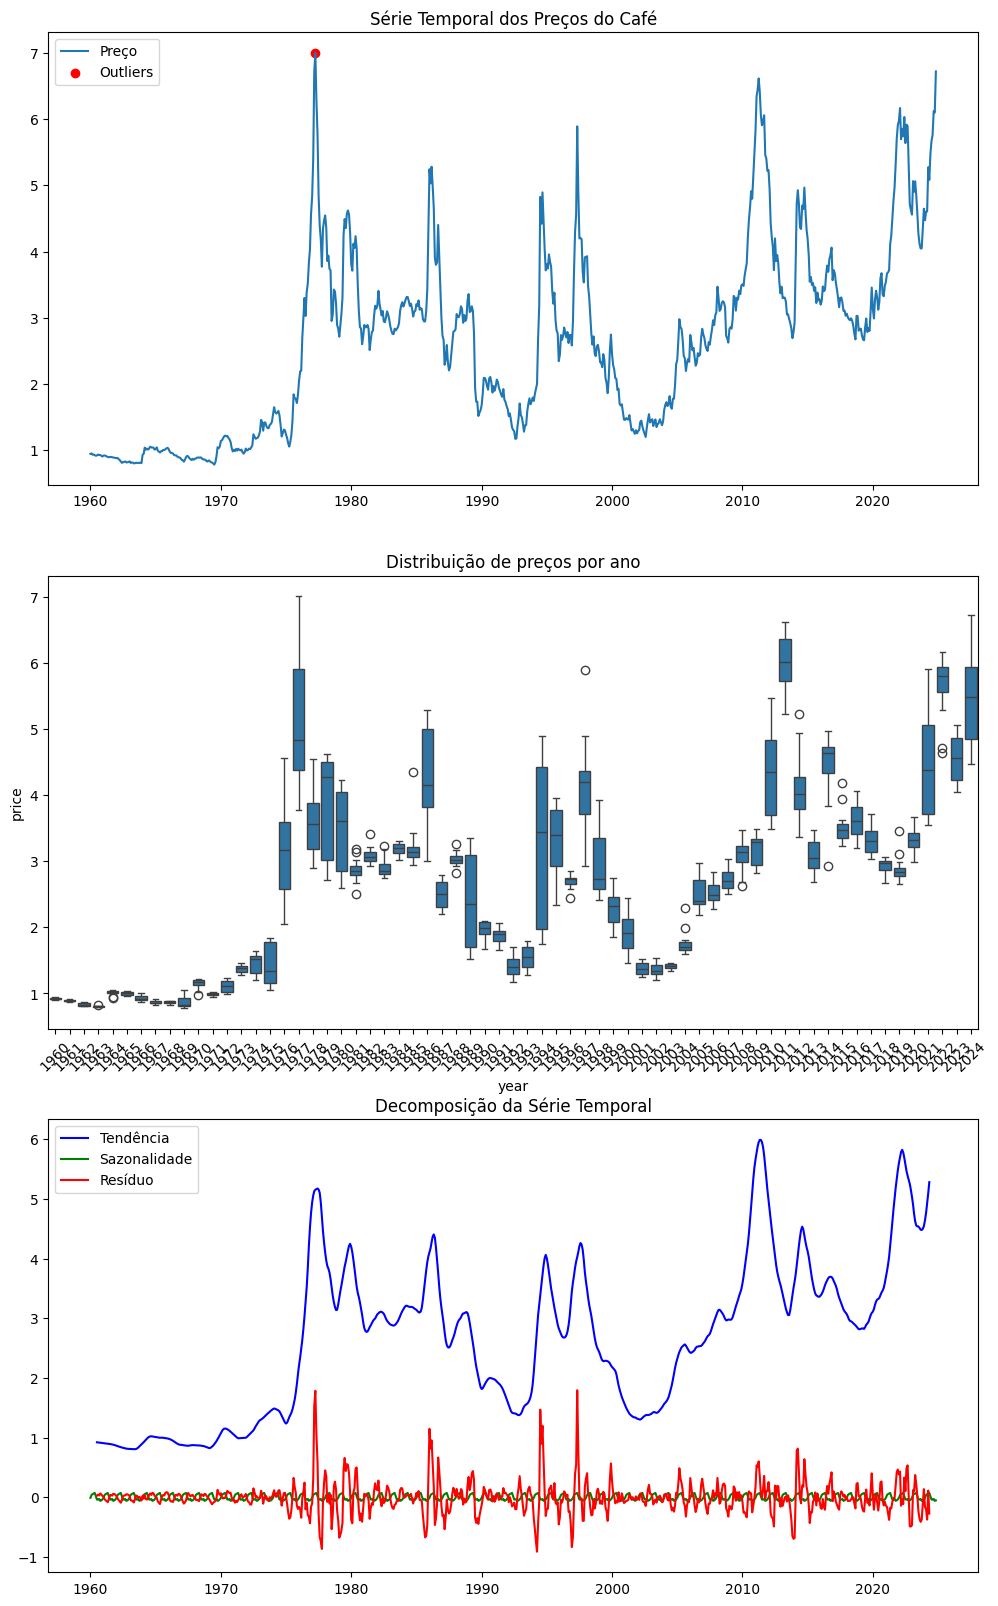

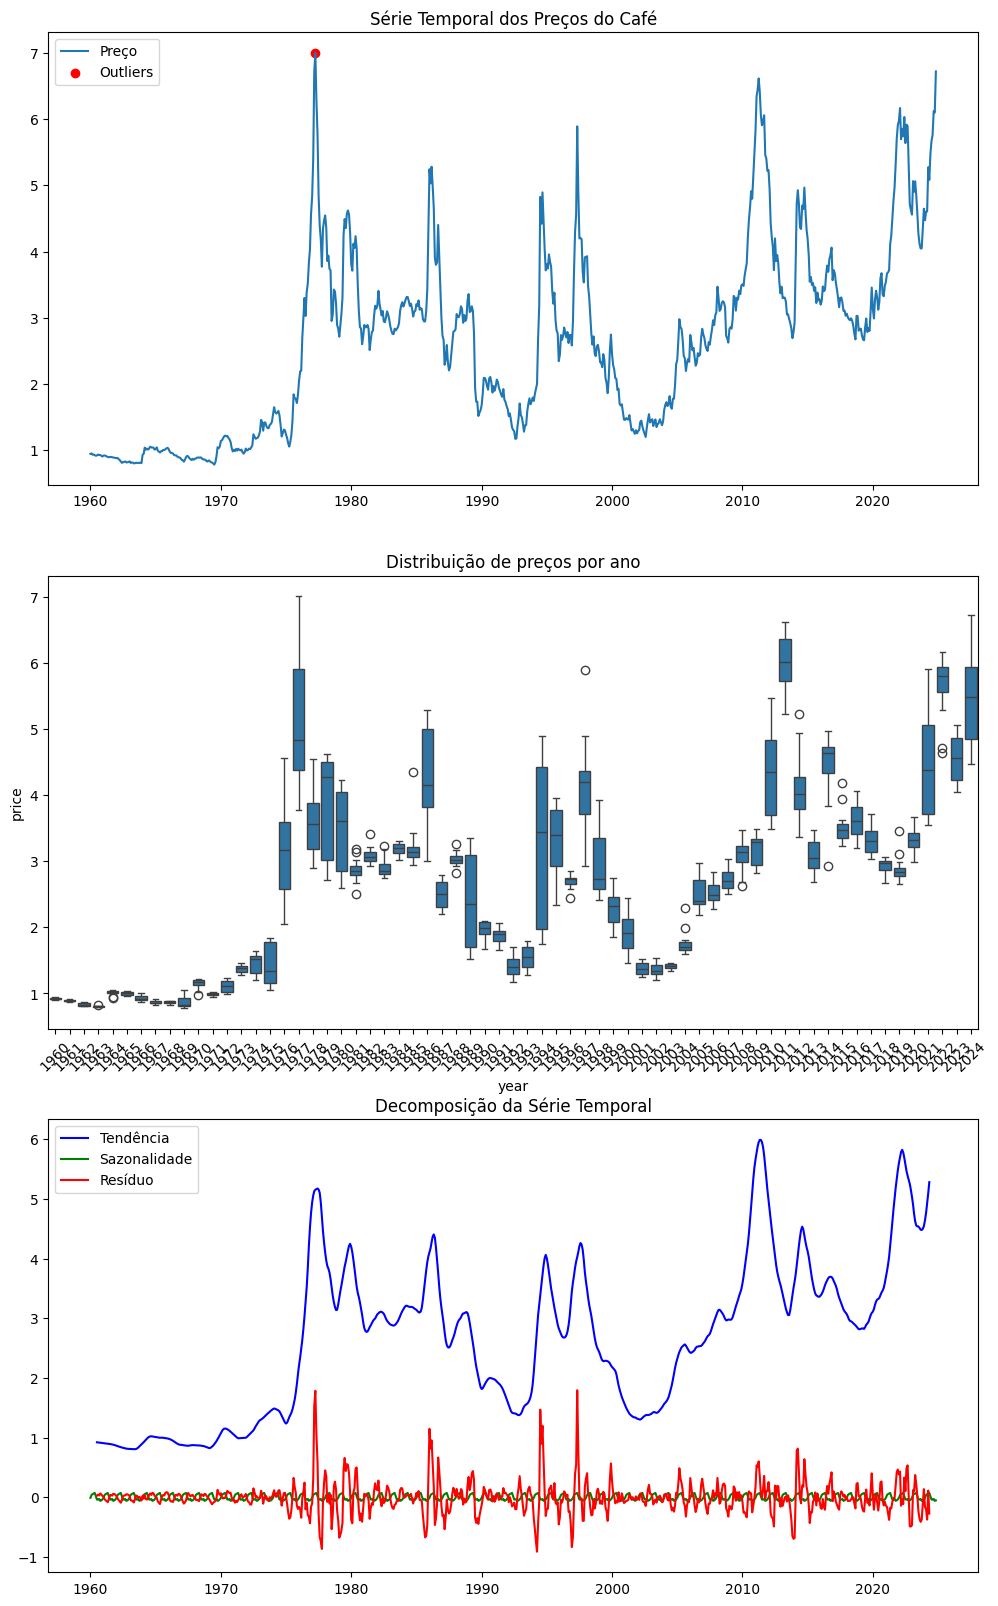

In [8]:
df = pd.read_excel(r'C:\Users\luizz\Documents\GitHub\portfolio\coffee-series-models\data\raw\coffee_word_bank.xlsx')

analyzer = CoffeTimeSeriesAnalysis(df)
#Gera visualizações básicas
analyzer.plot_analysis()


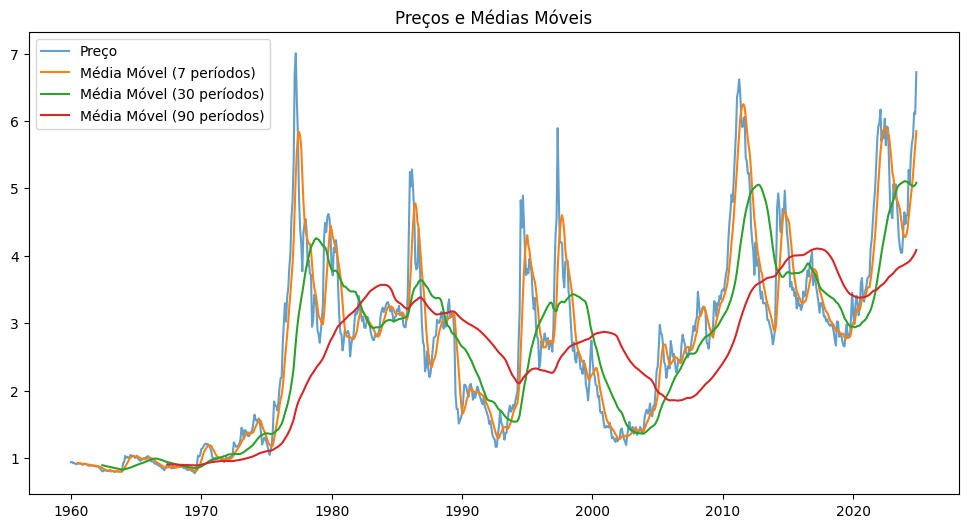

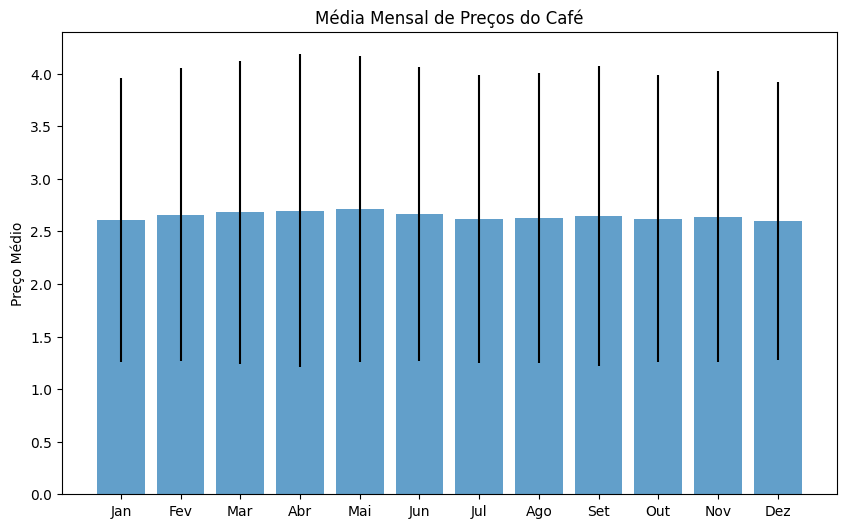

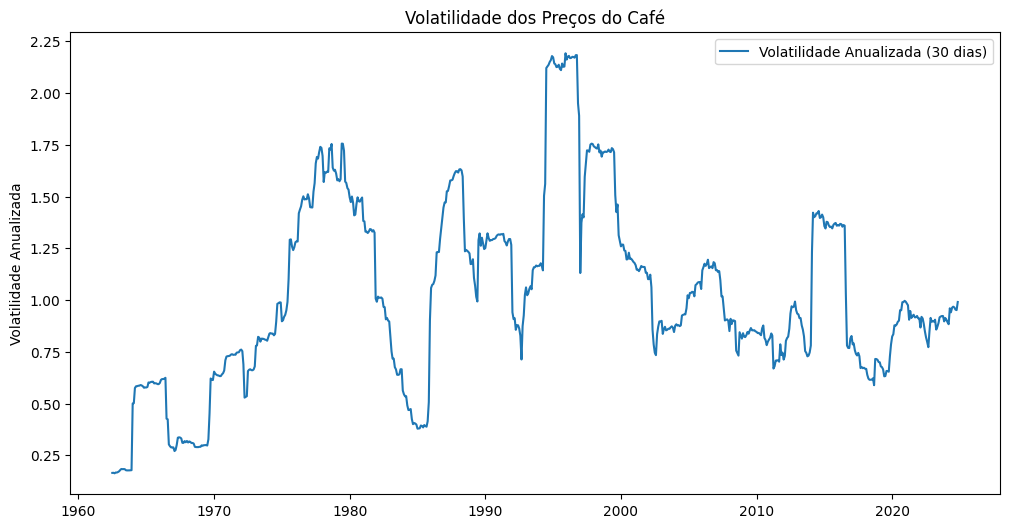

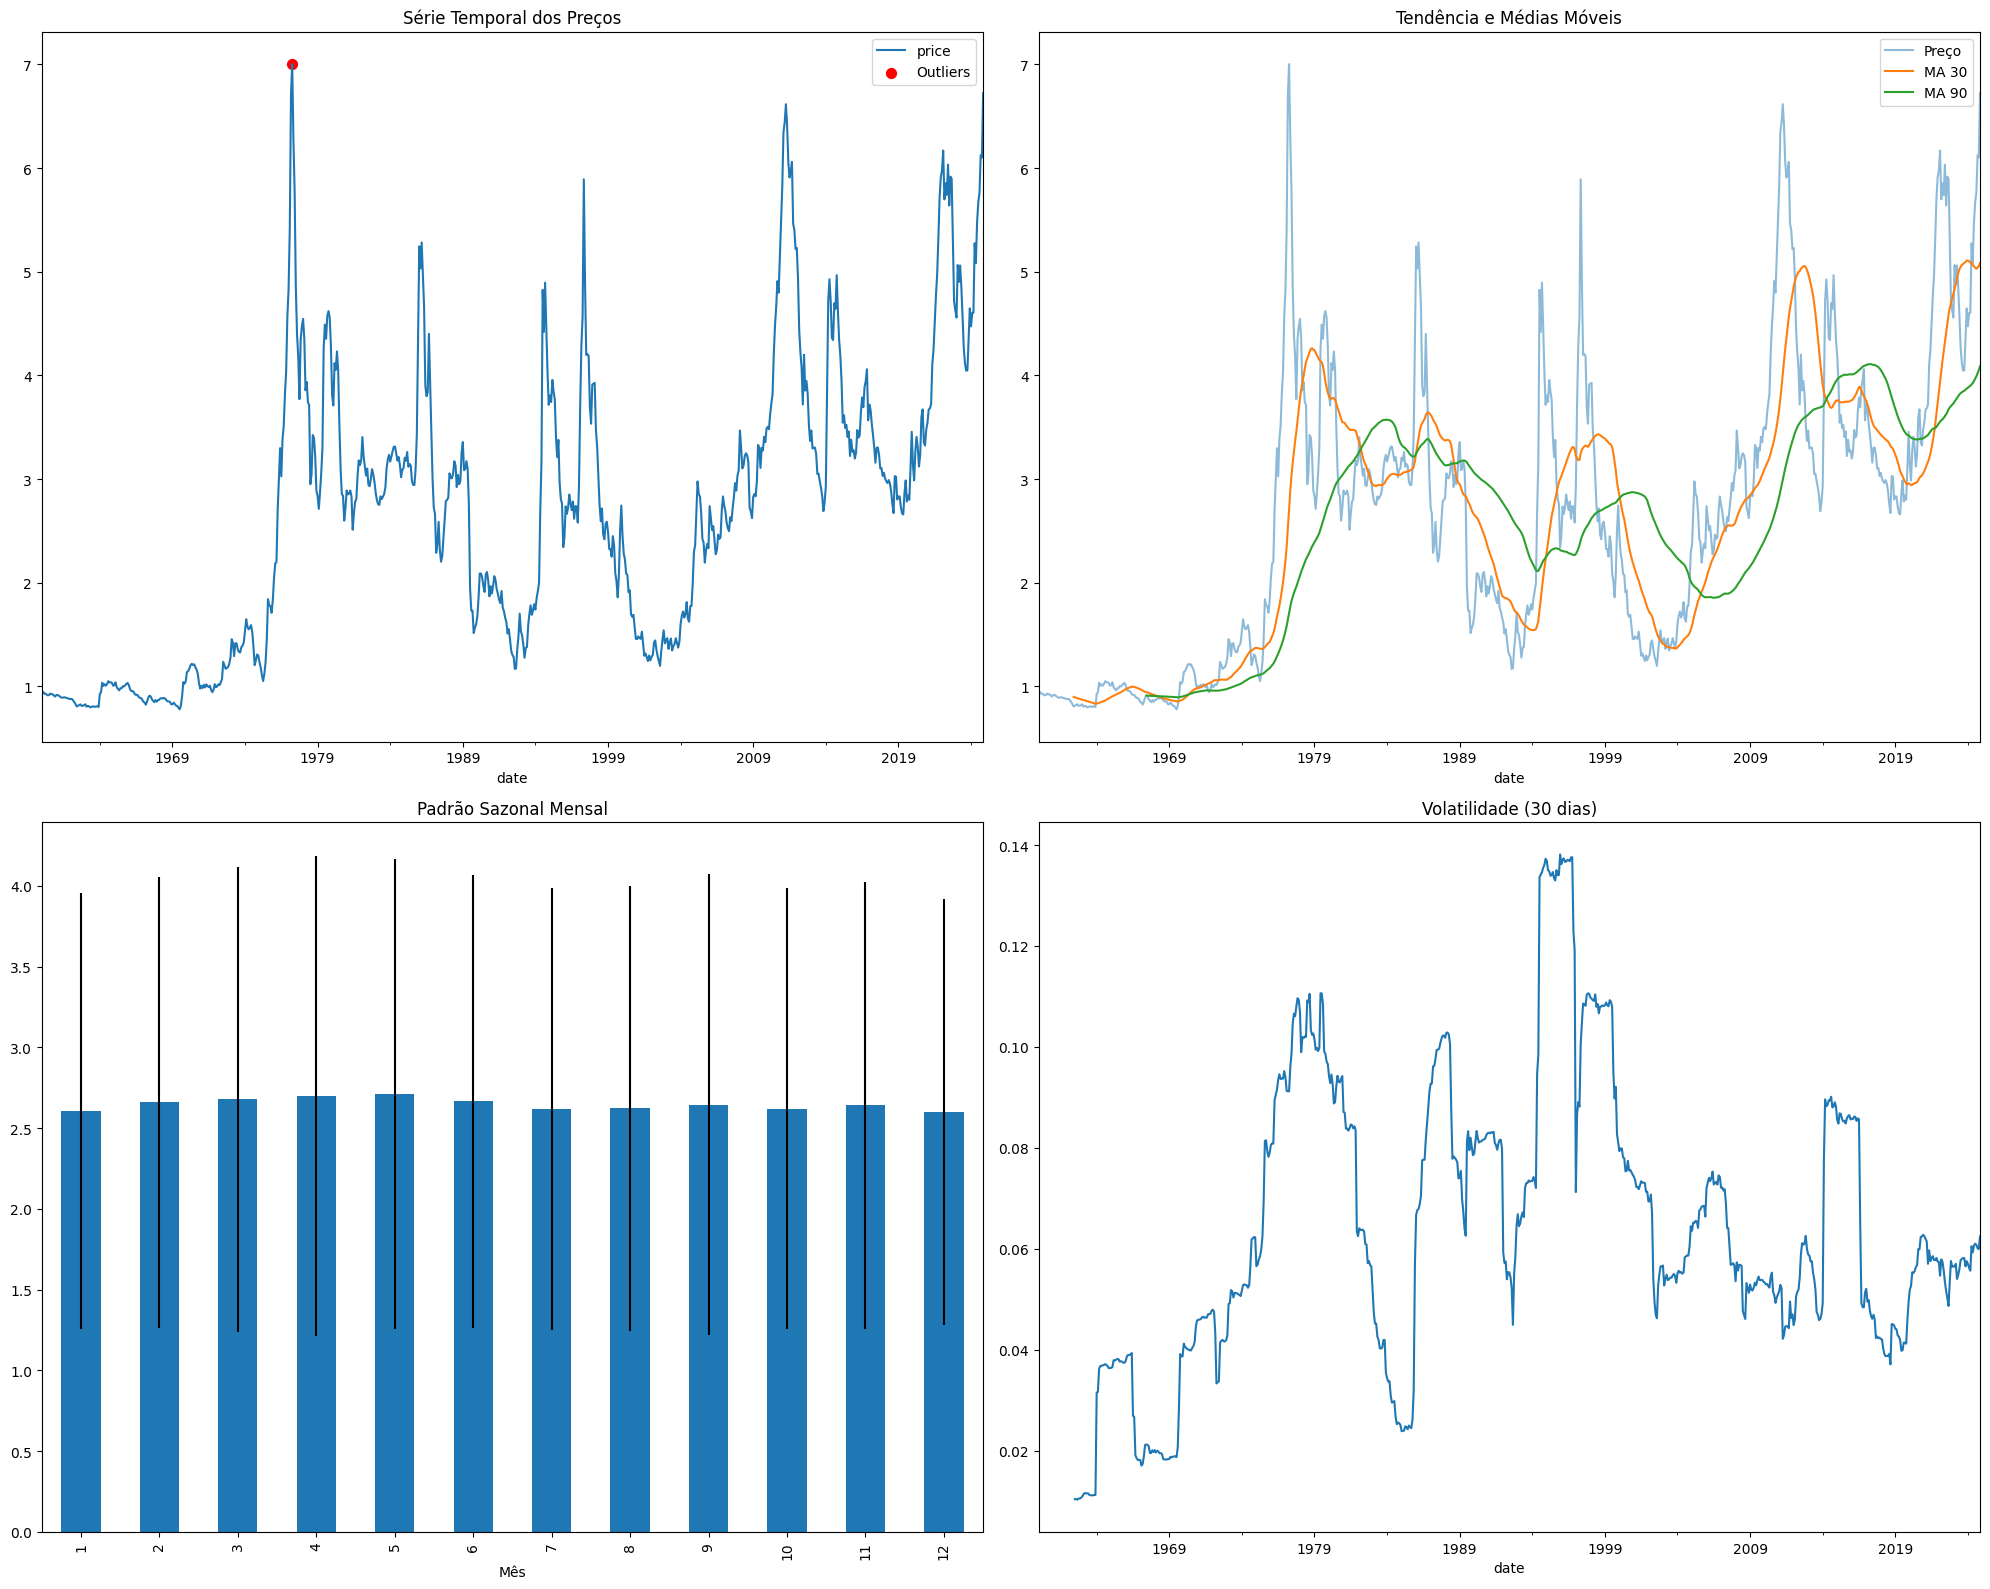

In [19]:
# Obter análise completa
summary = analyzer.generate_summary()

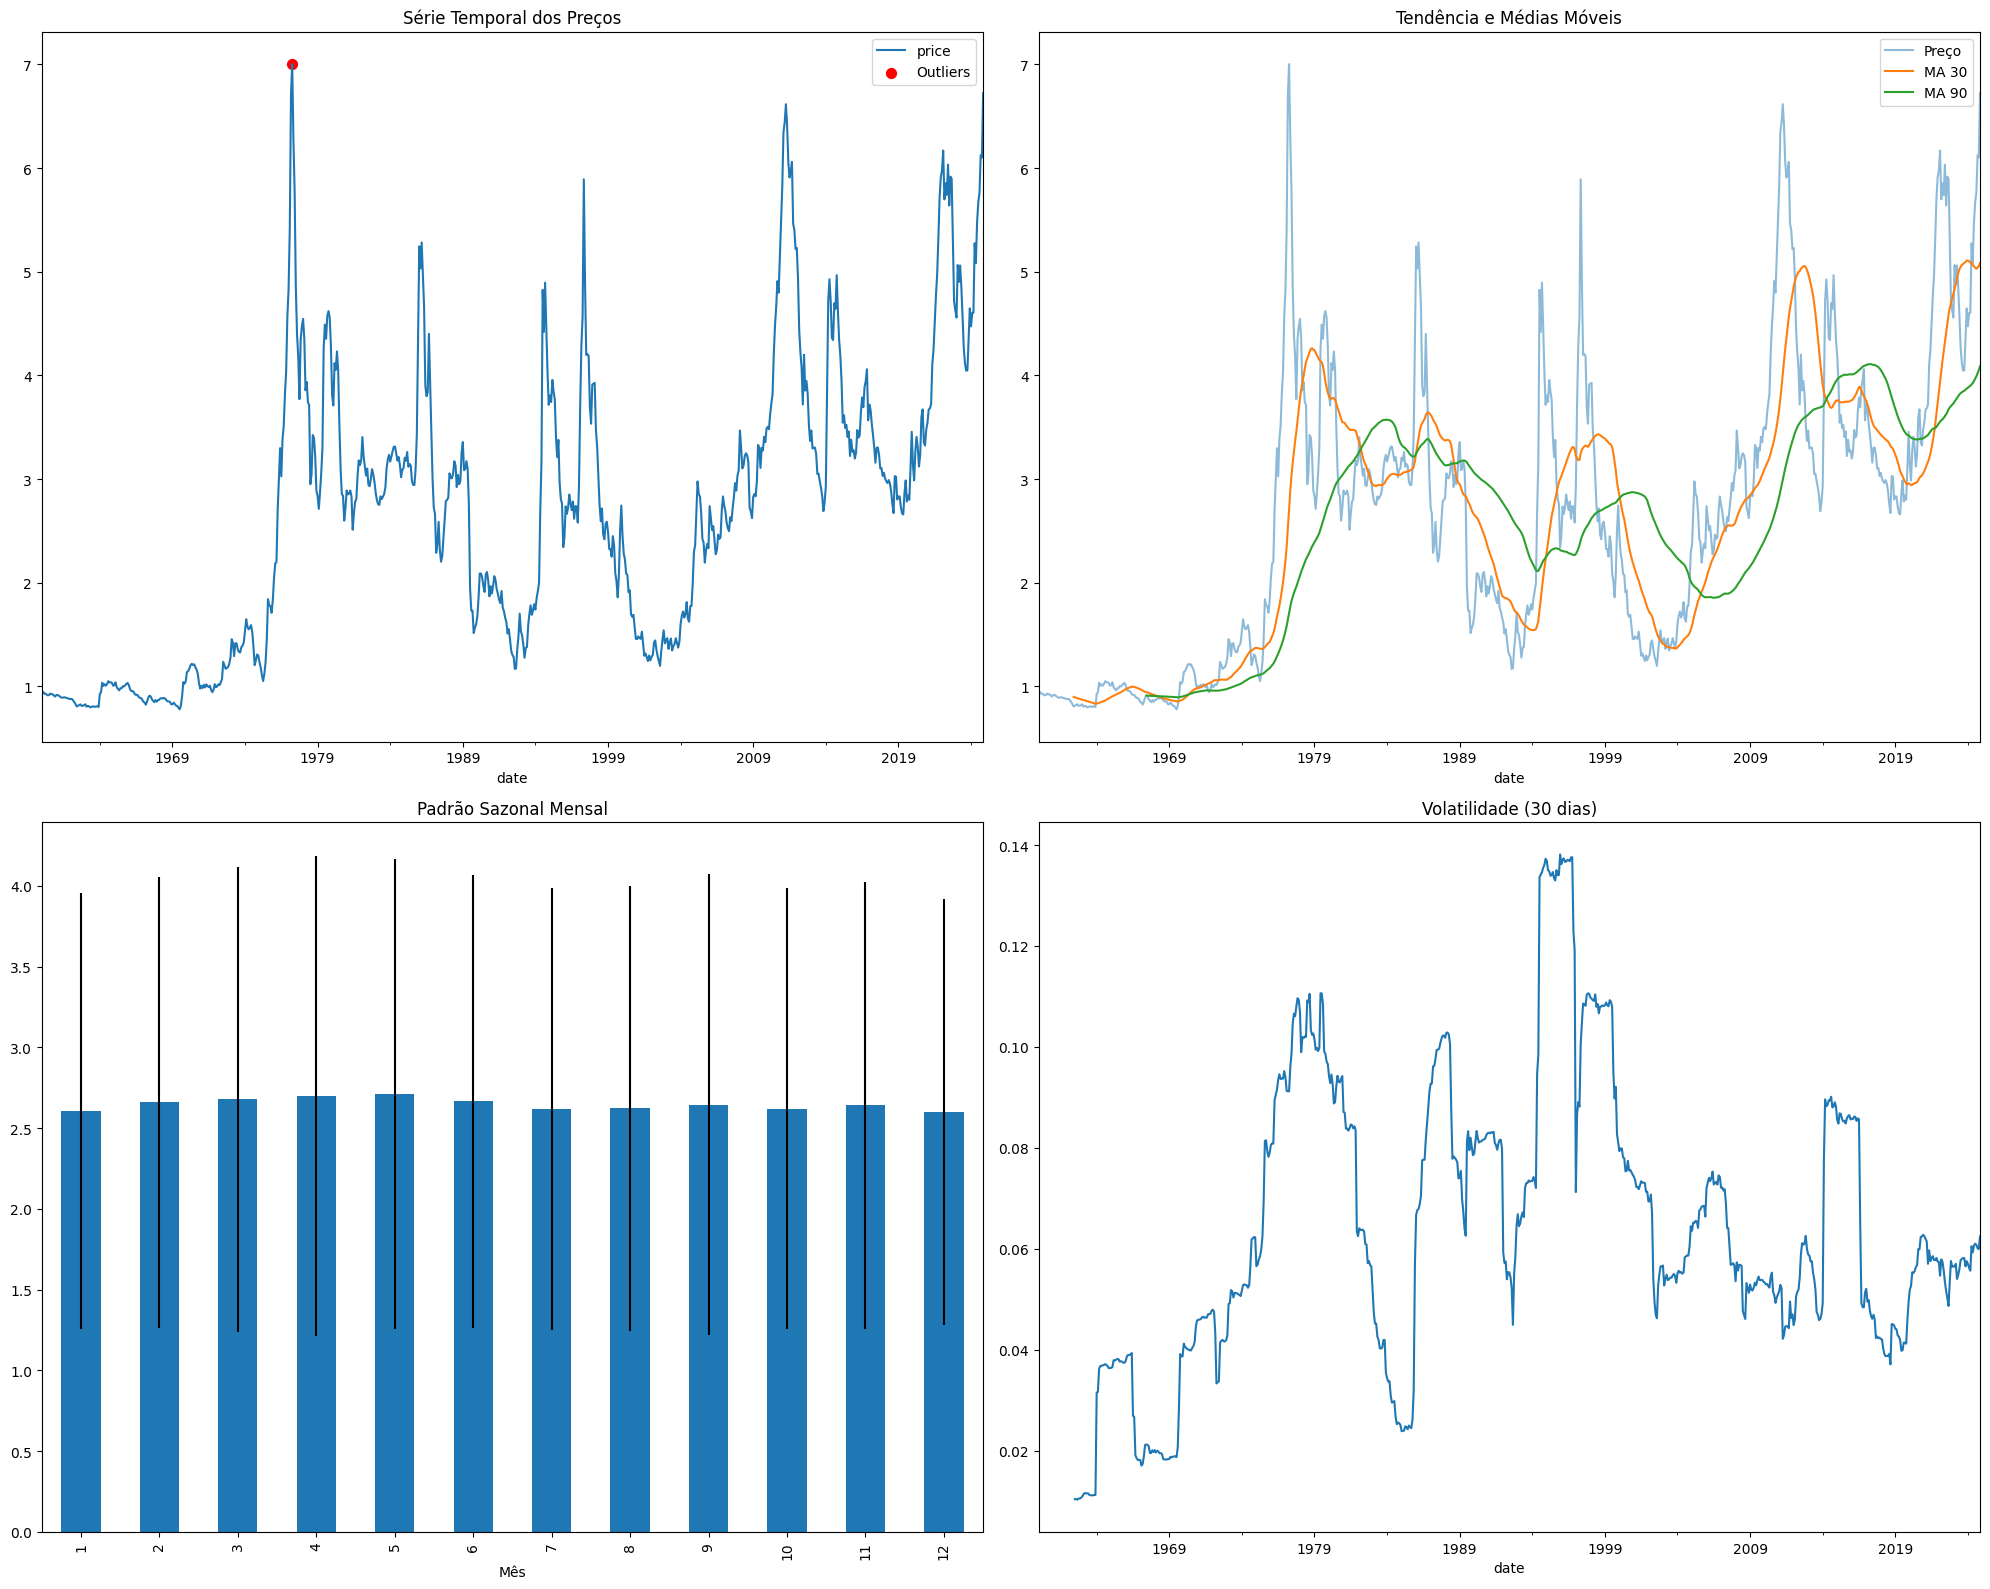

In [20]:
summary['trend_analysis']['plot']  # Gráfico de tendências
summary['seasonal_patterns']['plot']  # Gráfico de sazonalidade
summary['volatility_metrics']['plot']  # Gráfico de volatilidade
summary['summary_plot']  # Dashboard resumido